In [ ]:
import numpy as np
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn import metrics

from shutil import copyfile, copy
import re
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
import random

In [ ]:
print(cv2.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(np.__version__)
print(keras.__version__)
print(tf.__version__)

4.5.4-dev
3.3.4
1.0.1
1.20.1
2.7.0
2.7.0


In [ ]:
#specify data directory and results directory
data_dir = 'drive/MyDrive/DATA'
results_dir = 'drive/MyDrive/RESULTS'

In [ ]:
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#helper function to create custom directories
def create_dir(dir_path):
    try:
        os.mkdir(dir_path)
    except:
        pass

# 1. Extracting cards from `test-xxx`

To use cards from `test-xxx` to train the neural network, they have to be cropped out first. These images were taken with a smartphone camera from different angles and are much harder to work with compared to the flatbed scanned images. The cards are ultimately cropped out using an approach similar to that used in `Task-1`. 

The only differences are:- 
1. Threshold range used to filter out contours that are either too small or too large
2. Binarization is achieved using Otsu's thresholding instead of a hard simple threshold
3. Morphological Dilation is applied to try and distinguish the cards from the background better

In [ ]:
#read sample smartphone captured image
img = cv2.imread(os.path.join(data_dir, 'test-001.jpeg'))
#convert from BGR to RGB space for display purposes
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#create copies of the image to draw on at later stage
img2 = img.copy()
img3 = img.copy()

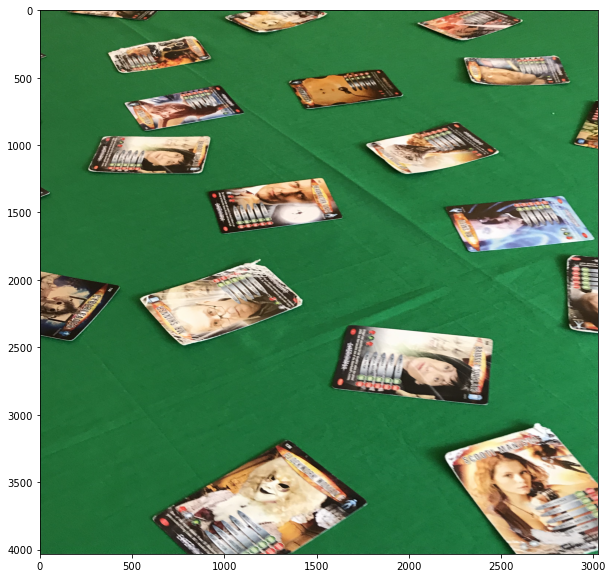

In [ ]:
#display original image
plt.figure(figsize = (10,10))
plt.imshow(img, aspect='auto')
plt.show()

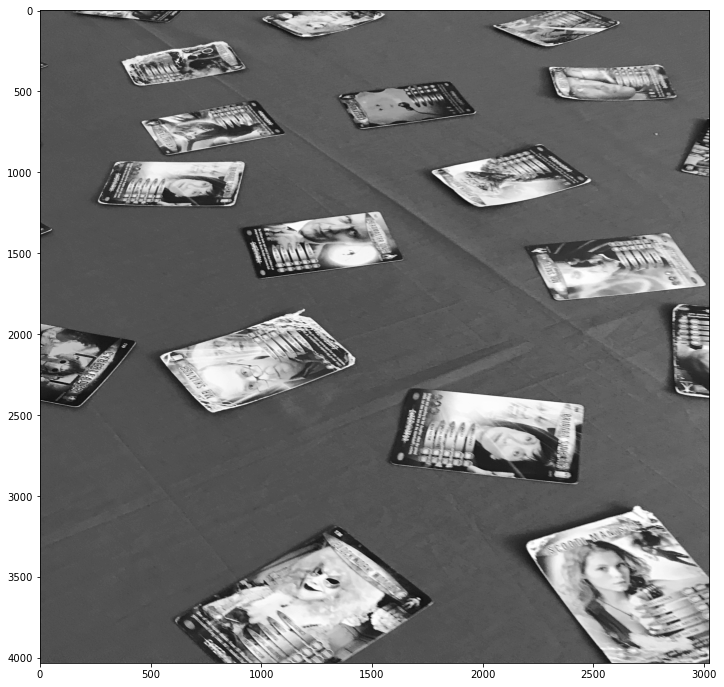

In [ ]:
#convert RGB image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (12,12))
plt.imshow(gray, aspect='auto', cmap='gray')
plt.show()

### Binarization

From the grayscale image, it is observed that the background is not as distinct from the cards compared to the flat-scanner images. More work will have to be done with the binarized image to distinguish the cards further.

Otsu's thresholding is used to identify an optimal threshold point for the given image automatically.

In [ ]:
ret2,otsu_thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize = (12,12))
plt.imshow(otsu_thresh, aspect='auto', cmap='gray')
plt.show()

### Morphological Dilation

openCV's dilation operation is used to try and enhance the white regions in the image that correspond to the cards.

In [ ]:
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(otsu_thresh,kernel,iterations = 5)
plt.figure(figsize = (12,12))
plt.imshow(dilation, aspect='auto', cmap='gray')
plt.show()

### Contour detection

Next, contour detection is performed with the expectation that it will identify the boundaries of each card.

As seen in the below example, the detection is not perfect but does a decent job of identifying the boundary where there is good contrast against the background.

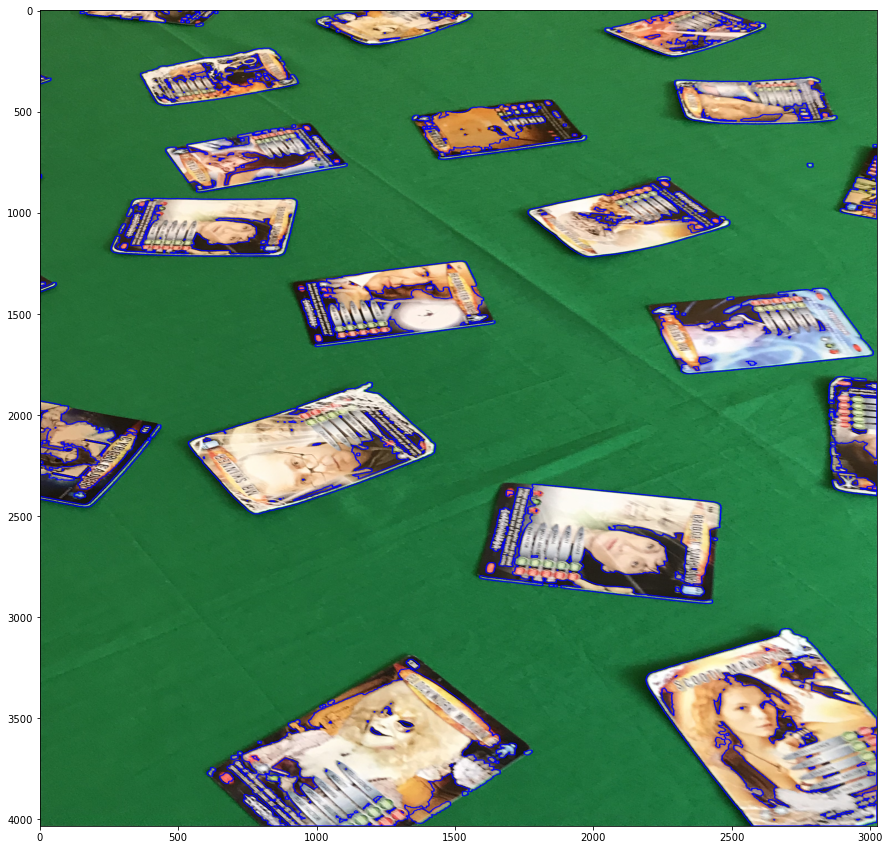

In [ ]:
contours, heirarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img2, contours, -1, (0,0,255), 3)
plt.figure(figsize = (15,15))
plt.imshow(img2, aspect='auto')
plt.show()

### Sort Contours

The contours are sorted so that larger contours (ideally the cards) can be focussed on. A threshold can be identified and set with experimentation to ignore contours that are either too large or too small.

One of the larger contours is displayed below for reference.

In [ ]:
cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

### Contour to box (not great)

Converting the contours to boxes as in `task-1` does not work well here for two reasons:-
1. The cards are arranged in a myriad of different orientations
2. The camera is not directly over the cards and thus there is a perspective skew

See below for an example where the rectangular box is not an accurate representation of the region containing the card.

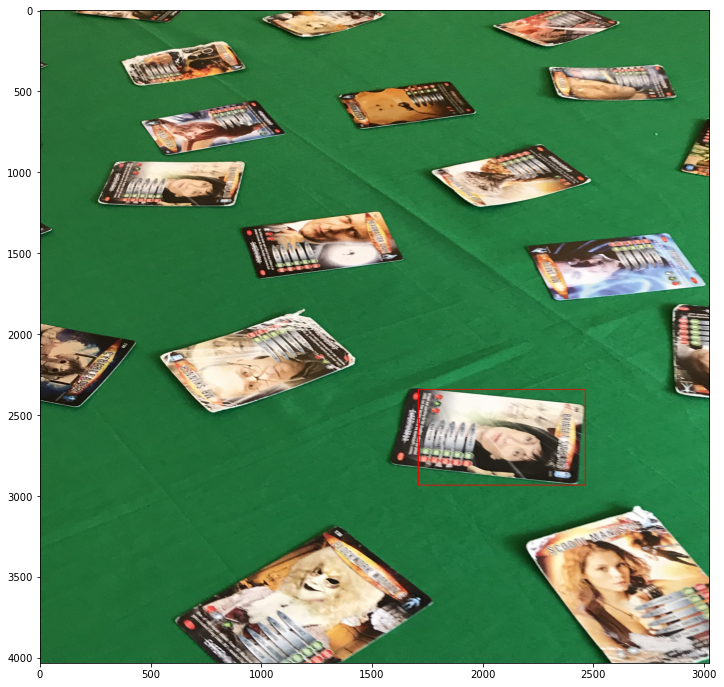

In [ ]:
x, y, w, h = cv2.boundingRect(cntsSorted[3])
cv2.rectangle(img3, (x,y), (x+w, y+h), (255,0,0), 3)
plt.figure(figsize = (12,12))
plt.imshow(img3, aspect='auto')
plt.show()

### Perspective Transform

To try and mitigate the above issue, below steps are employed:-
1. Approximate a polygon corresponding to the originally detected contour
2. Compute the rectangle that approximates the polygon
3. Apply a perspective transofrm on the rectangle

Area of minAreaRect:  335116


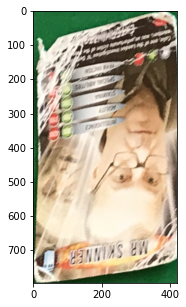

In [ ]:
img4 = img.copy()

cnt = cntsSorted[2]

#approximate polygon for the contour
perimeter = cv2.arcLength(cnt,True)
epsilon = 0.01*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

#find the rerctangle corresponding to the polygon
rect = cv2.minAreaRect(approx)
box = cv2.boxPoints(rect)
box = np.int0(box)

#perspective transform
#perspective transform
width = int(rect[1][0])
height = int(rect[1][1])
print("Area of minAreaRect: ", width*height)

src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(img, M, (width, height))

#display the transformed image
plt.figure(figsize=(5,5))
plt.imshow(warped)
plt.show()

# 2. Function to crop cards

The above mentioned steps are implemented inside a function to crop the cards out from `test-xxx`. The crops are stored in a directory called `phone_crops` within the results directory.

In [ ]:
create_dir(os.path.join(results_dir, 'phone_crops'))

In [ ]:
def crop_phone_image(img_path):
    phone_img_name = os.path.split(img_path)[-1].split('.')[0]
    
    #create directory corresponding to each 'test' image
    write_dir = os.path.join(results_dir, 'phone_crops', phone_img_name)
    create_dir(write_dir)
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret2,otsu_thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(otsu_thresh,kernel,iterations = 5)
    
    contours, heirarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    sorted_contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
#     cv2.drawContours(img2, contours, -1, (0,0,255), 3)
#     plt.figure(figsize = (15,15))
#     plt.imshow(img2, aspect='auto')
#     plt.show()
    
#     cnt = cntsSorted[17]

#     #simple bounding box crop
#     perimeter = cv2.arcLength(cnt,True)
#     epsilon = 0.01*cv2.arcLength(cnt,True)
#     approx = cv2.approxPolyDP(cnt,epsilon,True)
    
#     return None
    
    crop_count = 0
    for cnt in sorted_contours:
        perimeter = cv2.arcLength(cnt,True)
        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        rect = cv2.minAreaRect(approx)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        width = int(rect[1][0])
        height = int(rect[1][1])

        if (width*height) < 90000:
            print('Found {} cards in phone image {}'.format(crop_count, os.path.split(img_path)[-1]))
            break
            
        src_pts = box.astype("float32")
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(img, M, (width, height))
        
        cv2.imwrite(os.path.join(write_dir, str(crop_count)+'.jpg'), warped)
        crop_count += 1

In [ ]:
#creating list of 'test-xxx' images that will have to be processed
num_list = ['01','02','03','04','05','06','07','09','10']
phone_img_list = ['test-0{}.jpeg'.format(x) for x in num_list]
phone_img_list

['test-001.jpeg',
 'test-002.jpeg',
 'test-003.jpeg',
 'test-004.jpeg',
 'test-005.jpeg',
 'test-006.jpeg',
 'test-007.jpeg',
 'test-009.jpeg',
 'test-010.jpeg']

In [ ]:
#call the function to crop out the cards from smartphone images
for p in phone_img_list:
    crop_phone_image(os.path.join(data_dir, p))

Found 14 cards in phone image test-001.jpeg
Found 11 cards in phone image test-002.jpeg
Found 13 cards in phone image test-003.jpeg
Found 11 cards in phone image test-004.jpeg
Found 14 cards in phone image test-005.jpeg
Found 17 cards in phone image test-006.jpeg
Found 14 cards in phone image test-007.jpeg
Found 18 cards in phone image test-009.jpeg
Found 12 cards in phone image test-010.jpeg


## Custom mapping to associate cropped cards with their ID number

A mapping dictionary is created to associate each card with their ID number. This was done manually by verifying each card.

Note that the cropping from smartphone images is not perfect. Some of the really bad crops have been associated with an ID of `000` - this can be treated as an 'others' class.

In [ ]:
map_id = {
    
    'test-001':{
        0: '000',
        1: '138',
        2: '197',
        3: '189',
        4: '044',
        5: '147',
        6: '189',
        7: '109',
        8: '154',
        9: '114',
        10: '061',
        11: '015',
        12: '139',
        13: '138',
    },
    
    'test-002':{
        0: '197',
        1: '000',
        2: '147',
        3: '109',
        4: '189',
        5: '173',
        6: '044',
        7: '139',
        8: '189',
        9: '000',
        10: '001',
    },
    
    'test-003':{
        0: '000',
        1: '168',
        2: '138',
        3: '061',
        4: '039',
        5: '154',
        6: '134',
        7: '189',
        8: '056',
        9: '181',
        10: '061',
        11: '000',
        12: '061'
    },
    
    'test-004':{
        0: '114',
        1: '015',
        2: '138',
        3: '061',
        4: '154',
        5: '189',
        6: '109',
        7: '056',
        8: '147',
        9: '000',
        10: '134',
    },
    
    'test-005':{
        0: '172',
        1: '173',
        2: '109',
        3: '044',
        4: '147',
        5: '197',
        6: '076',
        7: '189',
        8: '063',
        9: '154',
        10: '189',
        11: '056',
        12: '000',
        13: '000'
    },
    
    'test-006':{
        0: '157',
        1: '172',
        2: '197',
        3: '173',
        4: '114',
        5: '109',
        6: '147',
        7: '044',
        8: '189',
        9: '076',
        10: '138',
        11: '138',
        12: '000',
        13: '001',
        14: '056',
        15: '189',
        16: '000'
    },
    
    'test-007':{
        0: '197',
        1: '138',
        2: '154',
        3: '147',
        4: '173',
        5: '044',
        6: '189',
        7: '189',
        8: '109',
        9: '139',
        10: '061',
        11: '138',
        12: '134',
        13: '056'
    },
    
    'test-009':{
        0: '154',
        1: '189',
        2: '147',
        3: '138',
        4: '109',
        5: '044',
        6: '139',
        7: '061',
        8: '000',
        9: '134',
        10: '168',
        11: '056',
        12: '061',
        13: '000',
        14: '000',
        15: '000',
        16: '000',
        17: '154',
    },
    
    'test-010':{
        0: '039',
        1: '109',
        2: '151',
        3: '168',
        4: '000',
        5: '061',
        6: '138',
        7: '134',
        8: '061',
        9: '168',
        10: '000',
        11: '000'
    }
}

# 3. Add cropped images to `all_data`

The cards cropped from `test-xxx` are added to the `all_data` directory which already contains the cards cropped from `train-xxx` grouped by card ID (Task-1). This combined dataset can then be used to train a CNN model with the objective of identifying the given card.

In [ ]:
class_counter = {}

for k in map_id:
    cur_dir = os.path.join(results_dir, 'phone_crops', k)
    cur_mapping = map_id[k]
    for f_name in os.listdir(cur_dir):
            #print(f_name)
            img_num = f_name.split('.')[0]
            #print(map_id[k])
            class_id = cur_mapping[int(img_num)]
            
            class_dir = os.path.join(results_dir, 'all_data', class_id)
            
            #create directory for the class
            
            if class_id not in class_counter:
                create_dir(class_dir)
                class_counter[class_id] = 1
            else:
                class_counter[class_id] += 1
            #copy file to train_data directory
            copy(os.path.join(cur_dir, f_name), os.path.join(class_dir, 'p_'+str(class_counter[class_id])+'.jpg'))

# 3. Load the data and train a CNN model

In [ ]:
#loading the list of all card ID's - i.e directories containing data
class_list = os.listdir(os.path.join(results_dir, 'all_data'))
class_list = [x for x in class_list if re.match(r'^\d{3}$', x)]
class_list

['184',
 '115',
 '028',
 '042',
 '187',
 '190',
 '146',
 '197',
 '044',
 '067',
 '045',
 '037',
 '198',
 '103',
 '080',
 '052',
 '048',
 '108',
 '017',
 '096',
 '059',
 '150',
 '173',
 '087',
 '161',
 '002',
 '015',
 '039',
 '076',
 '021',
 '191',
 '127',
 '129',
 '154',
 '172',
 '171',
 '193',
 '192',
 '174',
 '186',
 '056',
 '025',
 '004',
 '104',
 '069',
 '018',
 '026',
 '040',
 '131',
 '031',
 '007',
 '162',
 '060',
 '047',
 '135',
 '089',
 '133',
 '073',
 '138',
 '106',
 '111',
 '148',
 '065',
 '151',
 '092',
 '165',
 '005',
 '000',
 '181',
 '083',
 '136',
 '147',
 '109',
 '068',
 '114',
 '182',
 '066',
 '177',
 '010',
 '062',
 '101',
 '063',
 '134',
 '082',
 '142',
 '035',
 '170',
 '210',
 '157',
 '011',
 '183',
 '033',
 '160',
 '119',
 '125',
 '054',
 '168',
 '164',
 '120',
 '189',
 '001',
 '121',
 '061',
 '112',
 '124',
 '057',
 '036',
 '024',
 '156',
 '098',
 '196',
 '139']

In [ ]:
#get number of total classes
len(class_list)

112

### Loading the Data

Since there is a limited number of samples, some simple data augmentation techniques have been applied to create more samples. This helps avoid overfitting and create a more robust model.

While loading each image, an additional 3 images with the following augmentations are added to the dataset:-
1. 90 degree clockwise rotation
2. 90 degree anti-clockwise rotation
3. 180 degree rotation

Thus, for classes (Doctor Who characters) that contain even just one image, there will now be 4 samples at least for the model to work with.

In [ ]:
images = []
classes = []
class_count = 0

#class_to_id mapping will be used during inference to figure out the card ID corresponding to each class
class_to_id_mapping = {}

for class_id in class_list:
    cur_dir = os.path.join(results_dir, 'all_data', class_id)
    img_count = 0
    for f_name in os.listdir(cur_dir):
        img = cv2.imread(os.path.join(cur_dir, f_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        #resize image to a standard dimension of 128x128
        resized = cv2.resize(img, (128,128))
        #sub-list with original and additional 3 augmented images
        img_set = [resized] + [cv2.rotate(resized, cv2.ROTATE_90_CLOCKWISE)] + [cv2.rotate(resized, cv2.ROTATE_90_COUNTERCLOCKWISE)] + [cv2.rotate(resized, cv2.ROTATE_180)]
        
        #add the 4 image samples to dataset 
        images.extend(img_set)
        #add corresponding class label to dataset
        classes.extend([class_count]*4)
        img_count += 4
    
    class_to_id_mapping[class_count] = class_id
    class_count += 1
    print('Class {} has a total of {} images'.format(class_id, img_count))

Class 184 has a total of 4 images
Class 115 has a total of 4 images
Class 028 has a total of 4 images
Class 042 has a total of 4 images
Class 187 has a total of 4 images
Class 190 has a total of 8 images
Class 146 has a total of 12 images
Class 197 has a total of 24 images
Class 044 has a total of 28 images
Class 067 has a total of 8 images
Class 045 has a total of 4 images
Class 037 has a total of 4 images
Class 198 has a total of 12 images
Class 103 has a total of 4 images
Class 080 has a total of 4 images
Class 052 has a total of 16 images
Class 048 has a total of 8 images
Class 108 has a total of 8 images
Class 017 has a total of 8 images
Class 096 has a total of 8 images
Class 059 has a total of 4 images
Class 150 has a total of 8 images
Class 173 has a total of 20 images
Class 087 has a total of 4 images
Class 161 has a total of 4 images
Class 002 has a total of 4 images
Class 015 has a total of 20 images
Class 039 has a total of 12 images
Class 076 has a total of 16 images
Class

In [ ]:
class_to_id_mapping

{0: '184',
 1: '115',
 2: '028',
 3: '042',
 4: '187',
 5: '190',
 6: '146',
 7: '197',
 8: '044',
 9: '067',
 10: '045',
 11: '037',
 12: '198',
 13: '103',
 14: '080',
 15: '052',
 16: '048',
 17: '108',
 18: '017',
 19: '096',
 20: '059',
 21: '150',
 22: '173',
 23: '087',
 24: '161',
 25: '002',
 26: '015',
 27: '039',
 28: '076',
 29: '021',
 30: '191',
 31: '127',
 32: '129',
 33: '154',
 34: '172',
 35: '171',
 36: '193',
 37: '192',
 38: '174',
 39: '186',
 40: '056',
 41: '025',
 42: '004',
 43: '104',
 44: '069',
 45: '018',
 46: '026',
 47: '040',
 48: '131',
 49: '031',
 50: '007',
 51: '162',
 52: '060',
 53: '047',
 54: '135',
 55: '089',
 56: '133',
 57: '073',
 58: '138',
 59: '106',
 60: '111',
 61: '148',
 62: '065',
 63: '151',
 64: '092',
 65: '165',
 66: '005',
 67: '000',
 68: '181',
 69: '083',
 70: '136',
 71: '147',
 72: '109',
 73: '068',
 74: '114',
 75: '182',
 76: '066',
 77: '177',
 78: '010',
 79: '062',
 80: '101',
 81: '063',
 82: '134',
 83: '082',
 8

In [ ]:
#Pickling the class_to_id mapping as it will be required when running inference in Task-4

import pickle
with open(os.path.join(results_dir, 'class_ID_mapping.pkl'), 'wb') as f:
    pickle.dump(class_to_id_mapping, f)

In [ ]:
#total number of images in dataset
len(images)

1368

In [ ]:
#total number of classes
len(dict(Counter(classes)).keys())

112

In [ ]:
#Display a random image from the dataset
ix = random.choice(range(len(classes)))
test_img = images[ix]
test_class = classes[ix]

plt.figure(figsize=(7,7))
plt.imshow(test_img)
plt.title(test_class)
plt.show()

### Normalize the image pixel values and shuffle the dataset

In [ ]:
# convert data to numpy arrays and normalize
x = np.array(images).astype('float')/255.0
y = np.array(classes)

from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=0)

print('x shape is ', x.shape)
print('y shape is ', y.shape)

x shape is  (1368, 128, 128, 3)
y shape is  (1368,)


### Create a train-val split

Since the number of samples per class is not consistent, stratification is used to ensure the ratio of samples between the classes is maintained within both the train and val splits

In [ ]:
#from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in stratSplit.split(x, y):
    x_train, x_val = x[train_index], x[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
print('x_train shape is ', x_train.shape)
print('y_train shape is ', y_train.shape)

print('x_val shape is ', x_val.shape)
print('y_val shape is ', y_val.shape)

x_train shape is  (1094, 128, 128, 3)
y_train shape is  (1094,)
x_val shape is  (274, 128, 128, 3)
y_val shape is  (274,)


### Compute input dimensions based on Keras backend

In [ ]:
# input image dimensions
img_rows, img_cols, num_channels = images[0].shape

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], num_channels, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], num_channels, img_rows, img_cols)
    input_shape = (num_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, num_channels)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, num_channels)
    input_shape = (img_rows, img_cols, num_channels)
    
print('input_shape is ', input_shape)

input_shape is  (128, 128, 3)


### One hot encode the class labels

In [ ]:
from keras.utils import np_utils
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

print('one hot coded', y_train[0], ', class is ', np.argmax(y_train[0]))

one hot coded [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] , class is  71


### Define the CNN model architecture

In [ ]:
print('Input shape is ', input_shape)

num_classes = len(dict(Counter(classes)).keys())
model = Sequential()

#model.add(...)
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
#model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Input shape is  (128, 128, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooli

In [ ]:
batch_size = 32
epochs = 10


model.compile(loss='categorical_crossentropy',
              #loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
35/35 [==============================] - 4s 96ms/step - loss: 4.3717 - accuracy: 0.0649 - val_loss: 3.9231 - val_accuracy: 0.1168
Epoch 2/10
35/35 [==============================] - 3s 94ms/step - loss: 3.2343 - accuracy: 0.2916 - val_loss: 2.8100 - val_accuracy: 0.4270
Epoch 3/10
35/35 [==============================] - 3s 92ms/step - loss: 1.2766 - accuracy: 0.7166 - val_loss: 1.9873 - val_accuracy: 0.5912
Epoch 4/10
35/35 [==============================] - 3s 93ms/step - loss: 0.3443 - accuracy: 0.9141 - val_loss: 2.0142 - val_accuracy: 0.6460
Epoch 5/10
35/35 [==============================] - 3s 93ms/step - loss: 0.1263 - accuracy: 0.9689 - val_loss: 1.9142 - val_accuracy: 0.6898
Epoch 6/10
35/35 [==============================] - 3s 87ms/step - loss: 0.0509 - accuracy: 0.9899 - val_loss: 1.9191 - val_accuracy: 0.7007
Epoch 7/10
35/35 [==============================] - 3s 89ms/step - loss: 0.0119 - accuracy: 0.9991 - val_loss: 2.0461 - val_accuracy: 0.6861
Epoch 8/10
35

### Save model to disk

In [ ]:
model.save(os.path.join(results_dir, 'cnn_model.h5'))

### Plotting Losses

In [ ]:
#Plot train loss vs val loss
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x_val, y_val)

9/9 [==============================] - 0s 17ms/step - loss: 2.3170 - accuracy: 0.6898


[2.316997766494751, 0.6897810101509094]

The plot above suggests that the validation loss is slowly starting to creep up, therefore training further might just cause the model to overfit to the data.

With `10` epochs, the model achieved an accuracy of about `70%` on the validation set. Whether it has generalized enough to predict new samples can be explored in `Task-4`.